In [18]:
!git clone "https://github.com/openai/CLIP"
!git clone "https://github.com/CompVis/taming-transformers"

fatal: destination path 'CLIP' already exists and is not an empty directory.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1342 (delta 0), reused 1 (delta 0), pack-reused 1340
Receiving objects: 100% (1342/1342), 409.77 MiB | 39.18 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [19]:
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops

In [20]:
import numpy as np
import torch,os,imageio,pdb,math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import yaml
from omegaconf import OmegaConf

from CLIP import clip



In [21]:
def show_from_tensor(tensor):
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1,2,0))

  plt.figure(figsize=(10,7))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

def norm_data(data):
  return (data.clip(-1,1)+1)/2

learning_rate = .5
batch_size = 1
wd = .1
noise_factor = .22

total_iter=400
im_shape = [450, 450, 3]
size1, size2, channels = im_shape


In [22]:
clipmodel, _ = clip.load('ViT-B/32', jit=False)
clipmodel.eval()
print(clip.available_models())

print("Clip model visual input resolution: ", clipmodel.visual.input_resolution)

device=torch.device("cuda:0")
torch.cuda.empty_cache()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model visual input resolution:  224


In [23]:
%cd taming-transformers/

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if(len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints')))==0:
  !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
  !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'



/content/taming-transformers
--2024-01-14 14:03:25--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/19568b0f-33cf-46a8-adcc-439188b20b04/last.ckpt [following]
--2024-01-14 14:03:26--  https://heibox.uni-heidelberg.de/seafhttp/files/19568b0f-33cf-46a8-adcc-439188b20b04/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  15.6MB/s    in 63s     

2024-01-14 14:04:29 (14.9 MB/s) - ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ saved [980092370/980

In [25]:
from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
   config_data = OmegaConf.load(config_path)
   if display:
     print(yaml.dump(OmegaConf.to_container(config_data)))
   return config_data

def load_vqgan(config, chk_path=None):
  model = VQModel(**config.model.params)
  if chk_path is not None:
    state_dict = torch.load(chk_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
  return model.eval()

def generator(x):
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)


model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 66.9MB/s]


8.19kB [00:00, 85.4kB/s]                   


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [26]:
class Parameters(torch.nn.Module):
  def __init__(self):
    super(Parameters, self).__init__()
    self.data = .5*torch.randn(batch_size, 256, size1//16, size2//16).cuda()
    self.data = torch.nn.Parameter(torch.sin(self.data))

  def forward(self):
    return self.data

def init_params():
  params=Parameters().cuda()
  optimizer = torch.optim.AdamW([{'params':[params.data], 'lr': learning_rate}], weight_decay=wd)
  return params, optimizer



torch.Size([1, 256, 28, 28])
img dimensions:  torch.Size([1, 3, 448, 448])


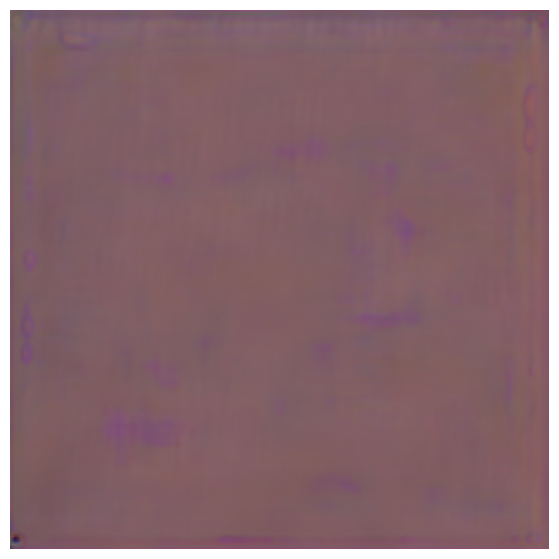

In [27]:
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def encodeText(text):
  t=clip.tokenize(text).cuda()
  t=clipmodel.encode_text(t).detach().clone()
  return t

def createEncodings(include, exclude, extras):
  include_enc=[]
  for text in include:
    include_enc.append(encodeText(text))
  exclude_enc=encodeText(exclude) if exclude != '' else 0
  extras_enc=encodeText(extras) if extras !='' else 0

  return include_enc, exclude_enc, extras_enc

augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2, .2), fill=0)
).cuda()

Params, optimizer = init_params()

with torch.no_grad():
  print(Params().shape)
  img= norm_data(generator(Params()).cpu())
  print("img dimensions: ",img.shape)
  show_from_tensor(img[0])



In [28]:
def create_crops(img, num_crops=32):
  p=size1//2
  img = torch.nn.functional.pad(img, (p,p,p,p), mode='constant', value=0) # 1 x 3 x 448 x 624 (adding 112*2 on all sides to 224x400)

  img = augTransform(img)

  crop_set = []
  for ch in range(num_crops):
    gap1= int(torch.normal(1.2, .3, ()).clip(.43, 1.9) * size1)
    offsetx = torch.randint(0, int(size1*2-gap1),())
    offsety = torch.randint(0, int(size1*2-gap1),())

    crop=img[:,:,offsetx:offsetx+gap1, offsety:offsety+gap1]

    crop = torch.nn.functional.interpolate(crop,(224,224), mode='bilinear', align_corners=True)
    crop_set.append(crop)

  img_crops=torch.cat(crop_set,0) ## 30 x 3 x 224 x 224

  randnormal = torch.randn_like(img_crops, requires_grad=False)
  num_rands=0
  randstotal=torch.rand((img_crops.shape[0],1,1,1)).cuda() #32

  for ns in range(num_rands):
    randstotal*=torch.rand((img_crops.shape[0],1,1,1)).cuda()

  img_crops = img_crops + noise_factor*randstotal*randnormal

  return img_crops




In [29]:
def showme(Params, show_crop):
  with torch.no_grad():
    generated = generator(Params())

    if (show_crop):
      print("Augmented cropped example")
      aug_gen = generated.float()
      aug_gen = create_crops(aug_gen, num_crops=1)
      aug_gen_norm = norm_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

    print("Generation")
    latest_gen=norm_data(generated.cpu())
    show_from_tensor(latest_gen[0])

  return (latest_gen[0])

In [30]:
def optimize_result(Params, prompt):
  alpha=1
  beta=.5
  out = generator(Params())
  out = norm_data(out)
  out = create_crops(out)
  out = normalize(out) # 30 x 3 x 224 x 224
  image_enc=clipmodel.encode_image(out) ## 30 x 512

  final_enc = w1*prompt + w1*extras_enc # prompt and extras_enc : 1 x 512
  final_text_include_enc = final_enc / final_enc.norm(dim=-1, keepdim=True) # 1 x 512
  final_text_exclude_enc = exclude_enc

  main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1) # 30
  penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1) # 30

  final_loss = -alpha*main_loss + beta*penalize_loss

  return final_loss

def optimize(Params, optimizer, prompt):
  loss = optimize_result(Params, prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss


In [31]:

def training_loop(Params, optimizer, show_crop=False):
  res_img=[]
  res_z=[]

  for prompt in include_enc:
    iteration=0
    Params, optimizer = init_params()

    for it in range(total_iter):
      loss = optimize(Params, optimizer, prompt)

      if iteration>=80 and iteration%show_step == 0:
        new_img = showme(Params, show_crop)
        res_img.append(new_img)
        res_z.append(Params())
        print("loss:", loss.item(), "\niteration:",iteration)

      iteration+=1
    torch.cuda.empty_cache()
  return res_img, res_z


In [32]:
torch.cuda.empty_cache()
include=['A painting of a pineapple in a bowl']
exclude='watermark'
extras = ""
w1=1
w2=1
noise_factor= .22
total_iter=110
show_step=10
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z=training_loop(Params, optimizer, show_crop=True)


Output hidden; open in https://colab.research.google.com to view.

In [33]:
print(len(res_img), len(res_z))
print(res_img[0].shape, res_z[0].shape)
print(res_z[0].max(), res_z[0].min())

3 3
torch.Size([3, 448, 448]) torch.Size([1, 256, 28, 28])
tensor(6.4544, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-5.9837, device='cuda:0', grad_fn=<MinBackward1>)


In [34]:
torch.cuda.empty_cache()
include=['A forest with purple trees', 'an elephant at the top of a mountain, looking at the stars','one hundred people with green jackets']
exclude='watermark, cropped, confusing, incoherent, cut, blurry'
extras = ""
w1=1
w2=1
noise_factor= .22
total_iter=110
show_step=total_iter-1
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z=training_loop(Params, optimizer, show_crop=False)


Output hidden; open in https://colab.research.google.com to view.

In [35]:
def interpolate(res_z_list, duration_list):
  gen_img_list=[]
  fps = 25

  for idx, (z, duration) in enumerate(zip(res_z_list, duration_list)):
    num_steps = int(duration*fps)
    z1=z
    z2=res_z_list[(idx+1)%len(res_z_list)]

    for step in range(num_steps):
      alpha = math.sin(1.5*step/num_steps)**6
      z_new = alpha * z2 + (1-alpha) * z1

      new_gen=norm_data(generator(z_new).cpu())[0]
      new_img=T.ToPILImage(mode='RGB')(new_gen)
      gen_img_list.append(new_img)

  return gen_img_list

durations=[5,5,5,5,5,5]
interp_result_img_list = interpolate(res_z, durations)

In [36]:
out_video_path=f"../video.mp4"
writer = imageio.get_writer(out_video_path, fps=25)
for pil_img in interp_result_img_list:
  img = np.array(pil_img, dtype=np.uint8)
  writer.append_data(img)

writer.close()

In [37]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('../video.mp4','rb').read()
data="data:video/mp4;base64,"+b64encode(mp4).decode()
HTML("""<video width=800 controls><source src="%s" type="video/mp4"></video>""" % data)

Output hidden; open in https://colab.research.google.com to view.